In [60]:
import pandas as pd
from scipy import stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import requests
from urllib.parse import urlencode

## Задание 1. A/B–тестирование

### 1.1 Условие

>Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

#### 1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:

- groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

- groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

- active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

- checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [61]:
# Ссылки на датасеты.

groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

# Функция для чтения через API Я.Диска.

def ydisk_api(public_key: str) -> str:
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(url)
    download = response.json()['href']
    return download

In [62]:
active_studs = pd.read_csv(ydisk_api(active_studs_url))
checks = pd.read_csv(ydisk_api(checks_url), sep=';')
group_add = pd.read_csv(ydisk_api(groups_add_url))
groups = pd.read_csv(ydisk_api(groups_url), sep=';')

### EDA для groups

In [63]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [64]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [65]:
groups.duplicated(subset=['id']).sum()

0

In [66]:
groups.shape

(74484, 2)

Количество строк: 74484  
Пропущенные значения и дубликаты отсутствуют 

### EDA для group_add

In [67]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [68]:
group_add.isna().sum()

id     0
grp    0
dtype: int64

In [69]:
group_add.duplicated(subset=['id']).sum()

0

In [70]:
group_add.shape

(92, 2)

Количество строк: 92   
Пропущенные значения и дубликаты отсутствуют 

### EDA для active_studs

In [12]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [13]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [14]:
active_studs.duplicated(subset=['student_id']).sum()

0

In [15]:
active_studs.shape

(8341, 1)

Количество строк: 8341  
Пропущенные значения и дубликаты отсутствуют

### EDA для checks

In [16]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [17]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [18]:
checks.duplicated(subset=['student_id']).sum()

0

In [19]:
checks.shape

(541, 2)

Количество строк: 541  
Пропущенные значения и дубликаты отсутствуют

### Посмотрим на распределение людей по группам
Для этого объединим два датафрейма в один

In [20]:
all_groups = pd.concat([groups, group_add])

In [21]:
#проверяем дубликаты в общей таблице
all_groups.duplicated(subset='id').sum()

0

In [22]:
all_groups.grp.value_counts(normalize=True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

Text(0.5, 0, 'group')

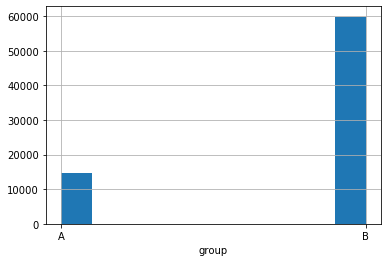

In [23]:
all_groups.grp.sort_values().hist()
plt.xlabel('group')

Количество людей в группах неравномерное

Оставим только тех, кто зашел на сайт в дни эксперимента. Используем inner join, т.к. нам нужно только совпадение тех, кто есть в группах с теми, кто зашел.

In [24]:
all_active_groups = pd.merge(active_studs, all_groups, how='inner', left_on='student_id', right_on='id')[['id', 'grp']]

Text(0.5, 0, 'group')

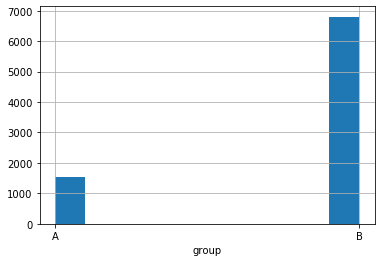

In [25]:
all_active_groups.grp.sort_values().hist()
plt.xlabel('group')

Вывод: группы набраны неравномерно. Проверим конверсию на вход на сайт в дни эксперимента. Предварительно она должна быть примерно одинаковой, так как измененная система оплаты не может влиять на решения клиента зайти на сайт. Если она различается, значит присутствуют ошибки в системе сплитования и наш эксперимент может не иметь смысл. 

### Проверим конверсию входа на сайт среди всех пользователей по группам. 

In [26]:
#создадим колонку с 1 для зашедших на сайт для удобства подсчета
active_studs['enter'] = 1

In [27]:
#создадим общую таблицу, где 1 - зашел на сайт, 0 - нет
all_users_entries = pd.merge(all_groups, active_studs, how='left', left_on='id', right_on='student_id').fillna(0)

In [28]:
CR_enterA = round(all_users_entries.query('grp == "A"').enter.sum() / all_users_entries.query('grp == "A"').shape[0] * 100, 2)

In [29]:
CR_enterB = round(all_users_entries.query('grp == "B"').enter.sum() / all_users_entries.query('grp == "B"').shape[0]* 100, 2)

Конверсия на вход в группе А 10.47, в группе B 11.36. Мы не будем статистически проверять различия данной метрики, поскольку она не является целевой для принятия решения. Здесь можно просто посмотреть "на глаз" - примерно одинаковая и это дает возможность нам двигаться дальше. 

### Посмотрим на конверсию в покупку среди тех, кто зашел на сайт
Конверсия в покупку - может являться нашей целевой метрикой, поскольку нам важно понимать, повлияла ли измененная система оплаты на принятие решение пользователя о покупке. 

In [30]:
#объединим тех, кто зашел на сайт и тех, кто совершил оплату
enter_and_buy = pd \
                    .merge(all_active_groups, checks, how='left', left_on='id', right_on='student_id') \
                    .fillna(0)[['id', 'grp', 'rev']]

In [31]:
CR_buyA = round(enter_and_buy.query('grp == "A" and rev != 0').shape[0] / enter_and_buy.query('grp == "A"').shape[0] * 100, 2)

In [32]:
CR_buyB = round(enter_and_buy.query('grp == "B" and rev != 0').shape[0] / enter_and_buy.query('grp == "B"').shape[0] * 100, 2)

In [33]:
print(f'Конверсия в оплату для группы А: {CR_buyA}%, для группы B: {CR_buyB}%')

Конверсия в оплату для группы А: 5.07%, для группы B: 4.62%


Конверсия в оплату так же на первый взгляд примерно одинакова.

### Считаем критерий хи-квадрат
Проверим, является ли различие в конверсии в покупку стат значимым - для этого посчиатем критерий хи-квадрат (данные дискретны, выборки независимы). 
Построим для этого таблицу сопряженности. Мы хотим проверить, зависит ли доля совершивших оплату от группы. Наша гипотеза H0: распределение не зависит от группы.

In [34]:
#для использования функции crosstab создадим столбец купил/не купил
# enter_and_buy['paid'] = np.where(enter_and_buy['rev'] > 0, 1, 0)

In [35]:
enter_and_buy['paid'] = pd.get_dummies(enter_and_buy.rev == 0)[1]

In [36]:
cross_table = pd.crosstab(enter_and_buy['grp'], enter_and_buy['paid'])

In [37]:
a, p_value, df, arr = ss.chi2_contingency(cross_table, correction=False)

In [38]:
round(p_value, 2)

0.45

Вывод: да, действительно, p_value превышает 0.05, значит различия не статзначимы. То есть распределение в двух группах одинаково, различия между ними по конверсии в оплату нет (либо размер выборки маловат)

### Теперь перейдем к исследованию выручки. 
Средний чек на пользователя также является важным показателем для нас. Для того, чтобы принять решение о критерии сравнения, необходимо для начала посмотреть и оценить нормальность распределения выручки по группам.

In [39]:
#создаем df отдельно для группы А
enter_and_buy_A = enter_and_buy.query('grp == "A" & rev != 0')

In [40]:
#создаем df отдельно для группы B
enter_and_buy_B = enter_and_buy.query('grp == "B" & rev != 0')

In [71]:
px.histogram(enter_and_buy[enter_and_buy['rev'] != 0], x='rev', color='grp', opacity=0.6)

Распределение отличается от нормального. Проверим с помощью стат. критериев

In [42]:
ss.shapiro(enter_and_buy_A.rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [43]:
ss.shapiro(enter_and_buy_B.rev)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

P-value значительно меньше 0.05, что подвтерждает первоначальный вывод о ненормальности распределения. 

Проверим дисперсию внутри групп


- H₀: Дисперсии данных о доходах в каждой группе не отличаются.
- H₁: Дисперсии статистически различаются.

In [44]:
levene_stat, p_value_levene = ss.levene(enter_and_buy_A.rev, enter_and_buy_B.rev)

In [58]:
print("Оставляем H₀ — дисперсии не имеют статистически значимых различий" if p_value_levene > 0.05 else 'Оставляем H₁ — статистически различаются')

Оставляем H₀ — дисперсии не имеют статистически значимых различий


Применим критерий Колмогорова-Смирнова

In [46]:
ss.kstest(enter_and_buy_A.rev, enter_and_buy_B.rev)

KstestResult(statistic=0.323942511840601, pvalue=2.3982639157926755e-06)

Вывод: pvalue ниже 0.05 следовательно мы отвергаем H0 и принимаем альтернативную - различия в выручке имеются.

### Рассчитаем основные метрики
Посмотрим на основные метрики по выручке ARPU и ARPAU. Активными будем считать тех, кто зашел на сайт. ARPU посчитаем по всем пользователям, попавшим в группу.
сделаю эту сразу с помощью функции

Задание 3. Python  
3.1 Задача  

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [47]:
def count_metrics(data, data_add, active_users, paying_users):
    data = data.rename(columns={data.columns[0]:'id', data.columns[1]: 'grp'})
    active_users['enter'] = 1 #сразу создадим колонку с 1(факт захода на сайт)
    data_add = data_add.rename(columns={data_add.columns[0]:'id', data_add.columns[1]: 'grp'})
    all_groups = pd.concat([data, data_add])
    all_data = pd.merge(all_groups, active_users, how='left', left_on='id', right_on='student_id') \
                 .fillna(0) \
                 .merge(paying_users, how='left', left_on='id', right_on='student_id').fillna(0) \
                 [['id', 'grp', 'enter', 'rev']]
    #можно добавить строку кода, очищающую дф от багов (купил, но не зашел)
    #но тк у меня в ф-ии прописаны конкретные условия расчета, то переделывать не вижу большого смысла
    #all_data = all_data.drop(all_data[(all_data.rev > 0) & (all_data.enter == 0)].index)
    all_data_A = all_data.loc[all_data['grp'] == 'A']
    all_data_B = all_data.loc[all_data['grp'] == 'B']
    metrics = {'A': {}, 'B': {}}
    #кто зашел/все кто в группе
    metrics['A']['CR_enter'] = all_data_A.enter.sum() / all_data_A.enter.count() * 100
    metrics['B']['CR_enter'] = all_data_B.enter.sum() / all_data_B.enter.count() * 100
    #количество зашедших и купивших / количество зашедших 
    metrics['A']['CR_buy'] = all_data_A.query('rev > 0 & enter > 0').rev.count() / all_data_A.enter.sum() * 100
    metrics['B']['CR_buy'] = all_data_B.query('rev > 0 & enter > 0').rev.count() / all_data_B.enter.sum() * 100
    #сумма выручки / количество людей в группе
    metrics['A']['ARPU'] = all_data_A.rev.sum() / all_data_A.rev.count()
    metrics['B']['ARPU'] = all_data_B.rev.sum() / all_data_B.rev.count()
    #сумма выручки кто зашел и купил / количество зашедших
    metrics['A']['ARPAU'] = all_data_A.query('rev > 0 & enter > 0').rev.sum() / all_data_A.enter.sum()
    metrics['B']['ARPAU'] = all_data_B.query('rev > 0 & enter > 0').rev.sum() / all_data_B.enter.sum()
    
    summary_table = pd.DataFrame(data=metrics).round(2)
    
    return summary_table

### Построим сводную таблицу

In [48]:
summary_table = count_metrics(groups, group_add, active_studs, checks)

In [73]:
summary_table

,A,B
CR_enter,10.47,11.36
CR_buy,5.07,4.62
ARPU,6.27,8.04
ARPAU,47.35,58.06


Для отслеживания успеха тестирования я бы выбрала две метрики это конверсия в платящего и средний чек на активного пользователя. Активного - потому что нам важно понимать, какой доход несет зашедший на сайт человек, вне зависимости от факта оплаты, т.к. за несовершившего покупку мы несем определенные расходы. Но расчеты и графики я бы оставила по всем 4 метрикам. 

### Построение графиков

In [49]:
def graph(summary_table):
    list_of_rows = summary_table.index.to_list()
    X = list_of_rows[:2]
    grA = summary_table.A[:2]
    grB = summary_table.B[:2]

    X_axis = np.arange(len(X)) 

    plt.bar(X_axis - 0.2, grA, 0.4, label = 'A') 
    plt.bar(X_axis + 0.2, grB, 0.4, label = 'B') 

    plt.xticks(X_axis, X) 
    plt.xlabel("Groups") 
    plt.ylabel("Percent") 
    plt.title("Metrics")
    plt.legend() 
    plt.show()
    
    X = list_of_rows[2:]
    grA = summary_table.A[2:]
    grB = summary_table.B[2:]

    X_axis = np.arange(len(X)) 

    plt.bar(X_axis - 0.2, grA, 0.4, label = 'A') 
    plt.bar(X_axis + 0.2, grB, 0.4, label = 'B') 

    plt.xticks(X_axis, X) 
    plt.xlabel("Groups") 
    plt.ylabel("Revenue, $") 
    plt.legend() 

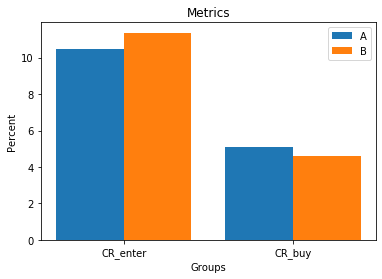

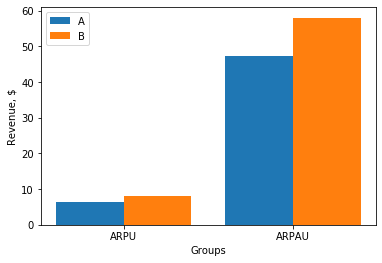

In [50]:
graph(summary_table)

In [51]:
#Взглянем еще раз на общую таблицу
summary_table

,A,B
CR_enter,10.47,11.36
CR_buy,5.07,4.62
ARPU,6.27,8.04
ARPAU,47.35,58.06


### Вывод

Вывод: наша целевая метрика это конверсия в оплату. Несмотря на то, что стат значимых различий не удалось зафиксировать, а при расчете фактических значений она даже меньше, чем была в контрольной группе, я бы все равно рекомендовала применить новую систему оплаты, потому что удалось зафиксировать стат значимые различия в средних чеках платящих пользователей. Это говорит о том, что наши улучшения не коснулись области принятия решения о покупке, возможно они не так очевидны на этом этапе. Но приняв решение о покупке (на основе других факторов) пользователь замечает удобство и либо покупает больше за раз, либо просто чаще (для этого нужна информация о количестве платежей или же с платежами по датам). 

## Задание 2. SQL

2.1 Очень усердные ученики.

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

```sql
select count(1) from (
select count(correct)
from peas
where correct=true
group by st_id, correct
having count(correct) >= 20) t1;
```

2.2
Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU   
ARPAU  
CR в покупку   
СR активного пользователя в покупку  
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.



```sql
Для удобства чтения запроса создадим CTE, где объединим всю информацию, чтобы из нее потом вытаскивать нужные расчеты.

with t1 as 
(
select st_id, 
       test_grp, 
       count(correct) AS all_tasks, 
       count(CASE WHEN correct = true THEN 1 END) as solved_tasks,  
       SUM(CASE WHEN Money is not NULL THEN money ELSE 0 END) revenue,
       count(peas.subject) filter(where peas.subject='Math' and correct=true) as math_tasks
from studs
left join peas using(st_id)
left join final_project_check using(st_id)
group by st_id, test_grp)

select test_grp, avg(revenue) AS ARPU,
avg(revenue) filter(where solved_tasks > 10 and revenue>0) AS ARPAU,
count(revenue) filter(where revenue > 0) / cast(count(revenue) as float) as CR,
count(revenue) filter(where revenue > 0 and solved_tasks > 10) / cast(count(revenue) filter(where solved_tasks > 10) as float) as CR_active,
count(revenue) filter(where math_tasks > 1 and revenue > 0) / cast(count(revenue) filter(where math_tasks > 1) as float) as math_active
from t1
group by test_grp
```